In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from utils_unet import * 
from utils_models import * 
from utils_data import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import pickle
import torch
from torch.utils.data import DataLoader, random_split,Dataset
import segmentation_models_pytorch as smp
from utils_unet import * 

from sklearn.metrics import r2_score, mean_squared_error, f1_score,confusion_matrix

In [7]:
plt.rcParams.update({'font.size': 17})

## Get data (train and validation)

In [8]:
# define target to be from 'precip_ncep' 'tmp_ncep' 'precip_nasa' 'tmp_nasa'
TARGET = 'precip_ncep'

PATH = '/share/data/willett-group/climate/'

In [10]:
ens_forecasts_all, target_rect, target_for_lags = get_train_val_ens_target(TARGET, PATH)

tmp_precip, rhum, ght, pressure, sst_train, sst_val = get_train_val_obs_data(TARGET, PATH)

mask_US = np.load('data/US_rect_mask_Larger_fixed.npy')

In [11]:
print(ens_forecasts_all.shape, target_rect.shape, mask_US.shape)

(312, 24, 64, 128) (312, 64, 128) (64, 128)


In [12]:
print(tmp_precip.shape, ght.shape, pressure.shape)

(324, 64, 128) (324, 64, 128) (324, 64, 128)


In [13]:
print(sst_train.shape, sst_val.shape)

(249, 100) (63, 100)


In [14]:
# let's define positional encoding

grid_lat, grid_lon = np.mgrid[52.75:21.25:64j, 233.25:296.75:128j]

coordinates = np.zeros((2, grid_lat.shape[0], grid_lat.shape[1]))
coordinates[0] = grid_lat
coordinates[1] = grid_lon

PE_dim = 12
pe0 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[0].reshape(64*128))
pe1 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[1].reshape(64*128))

pe_channels = np.zeros((PE_dim*2, 64, 128))
pe_channels[:PE_dim, :, :] = pe0.T.reshape(PE_dim, 64, 128)
pe_channels[-PE_dim:, :, :] = pe1.T.reshape(PE_dim, 64, 128)

In [15]:
train_val_size = 312

sst_ftr = np.concatenate((sst_train[:, :8], sst_val[:, :8]), axis=0)
sst_img = np.zeros((train_val_size, 8, 64, 128))

for i in range(train_val_size):
    for j in range(8): # number of components
        sst_img[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])

In [17]:
# create features 
# it's easy to vary what features to include
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    dim_shape = 24 + 24 + 5 + 4 + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :24, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 24, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 25, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 26, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 27, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 28, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 29, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 30, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 31, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 32, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_hind[:, -8:, :, :] = sst_img
    
elif TARGET == 'tmp_nasa' or TARGET == 'precip_nasa':
    print(TARGET)
    dim_shape = 11 + 4 + 24 + 5 + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :11, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 11, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 12, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 13, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 14, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 15, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 16, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 20:20+2*PE_dim, :, :] = pe_channels
    X_ftrs_hind[:, -8:, :, :] = sst_img

### Get test data 2011-2020 (2018)

In [18]:
ens_forecasts_all_test, target_test, precip_US_rect_old = get_test_ens_target(TARGET, PATH)

tmp_ssts_test, rhum_test, ght_test, pressure_test = get_test_obs_data(TARGET, PATH)

getting tmp


In [19]:
print(tmp_ssts_test.shape, ght_test.shape, pressure_test.shape)

(120, 64, 128) (120, 64, 128) (120, 64, 128)


In [20]:
TARGET

'precip_ncep'

In [21]:
if TARGET == 'precip_nasa' or TARGET == 'tmp_nasa':
    rhum = np.concatenate((rhum[-12:], rhum_test[:-11-24]), axis=0)
    ght = np.concatenate((ght[-12:], ght_test[:-11-24]), axis=0)
    pressure = np.concatenate((pressure[-12:], pressure_test[:-11-24]), axis=0)
    tmp_ssts = np.concatenate((tmp_ssts[-12:], tmp_ssts_test[:-11]), axis=0)
elif TARGET == 'precip_ncep':
    print('working with NCEP')
else:
    print('NO DATA')

working with NCEP


In [22]:
rhum.shape

(324, 64, 128)

In [23]:
if 'ncep' in TARGET:
    target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test), axis=0)
else:
     target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test[:-11]), axis=0)

In [24]:
if 'ncep' in TARGET:
    target_truth_test = target_test[3:] * mask_US
else:
    target_truth_test = target_test[:85] * mask_US

In [25]:
if 'nasa' in TARGET:
    sst_test = np.array(pd.read_pickle('sst_monthly_train_100PCs_2mo_offset_2011_2018.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((96, 8, 64, 128))
    for i in range(96):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[:-11]
elif 'ncep' in TARGET:
    sst_test = np.array(pd.read_pickle(PATH + 'data/test_2020/sst_monthly_test_100PCs_2mo_offset.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((120, 8, 64, 128))
    for i in range(120):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[3:]
else:
    print('NO DATA')

In [26]:
if TARGET == 'tmp_ncep' :
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i + 3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test
elif TARGET == 'precip_ncep':
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i +3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'precip_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i +12  -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'tmp_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i  +12 -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test

precip_ncep


In [27]:
X_ftrs_test.shape

(117, 65, 64, 128)

In [28]:
long_term_pctl_33, long_term_pctl_66 = get_quantiles_33_66(TARGET, PATH)    
print(long_term_pctl_33.shape, long_term_pctl_66.shape) 

geting precip prctl
(312, 64, 128) (312, 64, 128)


In [29]:
long_term_pctl_33[np.isnan(long_term_pctl_33)] = 0
long_term_pctl_66[np.isnan(long_term_pctl_66)] = 0
    
long_term_pctl_33_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_33_cropped[i] = crop_to_US_land(long_term_pctl_33[i])
    
long_term_pctl_66_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_66_cropped[i] = crop_to_US_land(long_term_pctl_66[i])

In [30]:
# here, we create labels for test data
if 'ncep' in TARGET:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[3:3+93+24]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[3:3+93+24]
else:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[:85]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[:85]

In [31]:
if TARGET == 'precip_nasa':
    labels_tercile_test = create_classif_labels_tercile(target_test[:-11], long_term_pctl_33[:85], 
                                               long_term_pctl_66[:85], mask_US)

elif TARGET == 'precip_ncep':
    labels_tercile_test = create_classif_labels_tercile(target_test[3:], long_term_pctl_33[3:3+93+24], 
                                               long_term_pctl_66[3:3+93+24], mask_US)

In [36]:
# train + test data
X_ftrs_train_test = np.concatenate((X_ftrs_hind[:249], X_ftrs_test), axis=0)
X_ftrs_train_test.shape

(366, 65, 64, 128)

In [32]:
labels_tercile_train_val = create_classif_labels_tercile(target_rect, 
                                                     long_term_pctl_33, 
                                               long_term_pctl_66, mask_US)

In [37]:
labels_terc = np.concatenate((labels_tercile_train_val[:249], labels_tercile_test), axis=0)

In [40]:
# train + val + test data
X_ftrs_train_val_test = np.concatenate((X_ftrs_hind, X_ftrs_test), axis=0)
labels_terc_all = np.concatenate((labels_tercile_train_val, labels_tercile_test), axis=0)
print(X_ftrs_train_val_test.shape, labels_terc_all.shape)

(429, 65, 64, 128) (429, 64, 128)


In [34]:
mask_US_cropped = crop_to_US_land(mask_US)

### Random Forest

In [41]:
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    print('ncep')
    rf_object = generate_RF_predictions(X_ftrs_train_val_test, labels_terc_all, mask_US,
                                        drop_positional_encodings=False,
                                        positional_encoding_channels=range(33, 33+2*PE_dim))
else:
    print('nasa')
    rf_object = generate_RF_predictions(X_ftrs_train_val_test, labels_terc_all, mask_US,
                                        drop_positional_encodings=False, 
                                    positional_encoding_channels=range(20, 20+2*PE_dim))

rf_object.train_model(rf=RandomForestClassifier(min_samples_leaf=2, max_features='sqrt', random_state=42, 
                                                    oob_score=True, max_depth=None, n_estimators=100, 
                                                n_jobs=-1))

rf_preds = rf_object.return_predictions(include='all', output_format='grid', 
                                         output_original_grid=False)

ncep


In [42]:
test_size = 312

In [44]:
print('RF tercile test', TARGET)

heatmap_terc = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                  rf_preds[test_size:, mask_US_cropped==1])

RF tercile test precip_ncep
Mean acc, median acc, SE: 42.38 41.88 0.13


In [87]:
print('RF tercile test', TARGET)

heatmap_terc = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                  rf_preds[test_size:, mask_US_cropped==1])

RF tercile precip_nasa
Mean acc, median acc, SE: 40.79 40.00 0.14


In [48]:
acc_test_rf_img = convert_1d_to_2d(heatmap_terc, mask_US_cropped)
acc_test_rf_img[:, mask_US_cropped==0] = np.float64('NaN')

<ipython-input-48-eb5287606e9d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_test_rf_img[:, mask_US_cropped==0] = np.float('NaN')


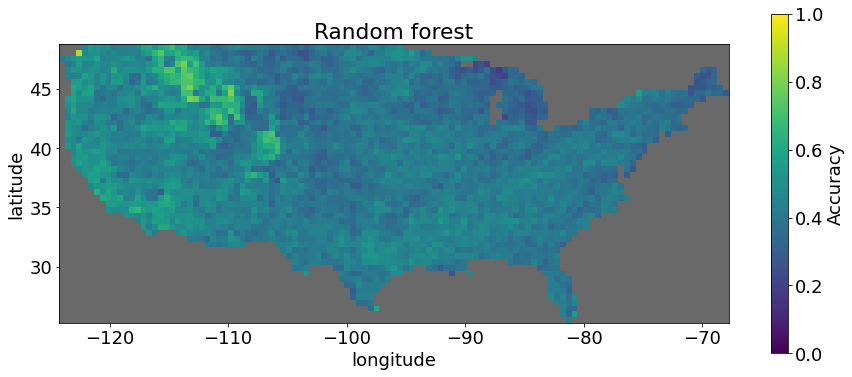

In [52]:
cmap = plt.cm.viridis
# cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
cmap.set_bad('dimgrey',1.)
plt.imshow(acc_test_rf_img[0], extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Random forest')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(0,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('Accuracy')
# plt.savefig('images/tercile_test_2020/precip/rf_precip_ncep_test_2011_2020.pdf', bbox_inches='tight')

### Linear regression

In [45]:
if 'nasa' in TARGET:
    preds_w_avg, preds_probs = get_LogRegr(X_ftrs_train_val_test[:, :11], labels_terc_all, mask_US, 
                              train_size=249, return_proba=True)
else:
    preds_w_avg, preds_probs = get_LogRegr(X_ftrs_train_val_test[:, :24], labels_terc_all, mask_US, 
                              train_size=249, return_proba=True)

In [46]:
preds_w_avg.shape

(429, 64, 128)

In [47]:
print('Logistic regr tercile', TARGET)

heatmap_terc = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                  preds_w_avg[test_size:, mask_US==1])

Logistic regr tercile precip_ncep
Mean acc, median acc, SE: 41.22 40.17 0.14


In [93]:
print('Logistic regr tercile', TARGET)

heatmap_terc = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                  preds_w_avg[test_size:, mask_US==1])

Logistic regr tercile precip_nasa
Mean acc, median acc, SE: 41.51 40.00 0.16


### Ensemble average

In [48]:
ens_avg_test = np.mean(ens_forecasts_all_test, axis=1)

if 'nasa' in TARGET:
    labels_ens_avg_test = create_classif_labels_tercile(ens_avg_test, long_term_pctl_33[:85], 
                                               long_term_pctl_66[:85], mask_US)
else:
    labels_ens_avg_test = create_classif_labels_tercile(ens_avg_test, long_term_pctl_33[3:3+93+24], 
                                               long_term_pctl_66[3:3+93+24], mask_US)

In [49]:
labels_terc.shape, labels_ens_avg_test.shape

((366, 64, 128), (117, 64, 128))

In [50]:
print(TARGET, 'ens avg')
heatmap_acc_ens = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                 labels_ens_avg_test[:, mask_US==1])

precip_ncep ens avg
Mean acc, median acc, SE: 38.01 37.61 0.16


In [96]:
print(TARGET, 'ens avg')
heatmap_acc_ens = report_terc_scores(labels_terc_all[test_size:, mask_US==1], 
                                 labels_ens_avg_test[:, mask_US==1])

precip_nasa ens avg
Mean acc, median acc, SE: 38.64 37.65 0.14


### UNET 

In [29]:
train_size = 249 


X_train = X_ftrs_train_test[:train_size]
X_test = X_ftrs_train_test[train_size:]
y_train = labels_terc[:train_size]
y_test = labels_terc[train_size:]

X_mins = np.min(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_train_test.shape[1], 1, 1) 
X_maxs = np.max(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_train_test.shape[1], 1, 1) 
X_train = X_train - X_mins
X_test = X_test - X_mins
X_train = X_train/(X_maxs - X_mins)
X_test = X_test/(X_maxs - X_mins)


In [30]:
BATCH_SIZE = 8
LR = 0.001

In [31]:
dataset_train = SimpleDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


dataset_test = SimpleDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test,
                              batch_size=64,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [32]:
def transform_output_terc(model_output,y):
    out_1d = model_output[:,:,US_mask_tensor==1].reshape(y.shape[0], 3, -1)
    y_1d = y[:,US_mask_tensor==1].reshape(y.shape[0], -1)
    return out_1d, y_1d

In [33]:
! echo $CUDA_VISIBLE_DEVICES

1


In [34]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
US_mask_tensor = torch.from_numpy(mask_US).float()

In [47]:
classes = 3
activation = None
distance = smp.utils.losses.CrossEntropyLoss()
transform_output = transform_output_terc

model = smp.Unet(
    encoder_name="vgg11",        
    encoder_weights=None,     
    in_channels=X_ftrs_train_test.shape[1],                 
    classes=classes,                      
    activation=activation).to(device)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=LR),])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [48]:
num_epochs = 90
losses = []
losses_test = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    with tqdm(total=len(dataloader_train), desc=f"[Epoch {epoch+1:3d}/{num_epochs}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            x, y = x.to(device).float(), y.to(device).float()

            output = model(x)
            model_output, target = transform_output(output, y)
            loss = distance(model_output, target.long())
            
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.update(x.shape[0])
        
        scheduler.step()
        train_loss = running_loss/len(dataloader_train)
        losses.append(train_loss)
        
        pbar.set_postfix({'train loss': train_loss})
        pbar.update(x.shape[0])

        # validation 
#         model.eval()
#         with torch.no_grad():
#             running_loss = 0
#             for x, y in dataloader_test:
#                 x, y = x.to(device).float(), y.to(device).float()

#                 output = model(x)
#                 model_output, target = transform_output(output, y.long())
#                 loss = distance(model_output, target)
# #                 loss = distance(output.squeeze() * US_mask_tensor.to(device), y)
#                 running_loss += loss.item()

#         test_loss = running_loss/len(dataloader_test)
#         losses_test.append(test_loss)

[Epoch   1/90]: 250it [00:01, 182.48it/s, train loss=1.12]      
[Epoch   2/90]: 250it [00:01, 181.38it/s, train loss=1.1]       
[Epoch   3/90]: 250it [00:01, 182.79it/s, train loss=1.1]       
[Epoch   4/90]: 250it [00:01, 182.89it/s, train loss=1.09]      
[Epoch   5/90]: 250it [00:01, 191.63it/s, train loss=1.09]      
[Epoch   6/90]: 250it [00:01, 177.93it/s, train loss=1.09]      
[Epoch   7/90]: 250it [00:01, 181.06it/s, train loss=1.08]      
[Epoch   8/90]: 250it [00:01, 170.05it/s, train loss=1.08]      
[Epoch   9/90]: 250it [00:01, 185.19it/s, train loss=1.07]      
[Epoch  10/90]: 250it [00:01, 178.89it/s, train loss=1.07]      
[Epoch  11/90]: 250it [00:01, 179.60it/s, train loss=1.07]      
[Epoch  12/90]: 250it [00:01, 178.56it/s, train loss=1.07]      
[Epoch  13/90]: 250it [00:01, 170.31it/s, train loss=1.07]      
[Epoch  14/90]: 250it [00:01, 171.21it/s, train loss=1.07]      
[Epoch  15/90]: 250it [00:01, 180.94it/s, train loss=1.07]      
[Epoch  16/90]: 250it [00

In [54]:
# model = torch.load('models/model_UNET_precip_terc_nasa_041.pth')
model.to(device);

In [53]:
# torch.save(model.to('cpu'),'models/model_UNET_precip_terc_nasa_new.pth')

In [49]:
model.eval();
pred_all = pred(model, dataloader_train, dataloader_test, US_mask_tensor, device=device)
pred_all = pred_all.squeeze()

In [55]:
pred_all.shape

(334, 3, 64, 128)

In [129]:
print('UNET tercile', TARGET)

heatmap_terc = report_terc_scores(labels_terc[train_size:, mask_US==1], 
                                  np.argmax(pred_all, axis=1)[train_size:, mask_US==1])

UNET tercile precip_nasa
Mean acc, median acc, SE: 37.99 37.65 0.12


In [141]:
print('UNET tercile', TARGET)

heatmap_terc = report_terc_scores(labels_terc[train_size:, mask_US==1], 
                                  np.argmax(pred_all, axis=1)[train_size:, mask_US==1])

UNET tercile precip_nasa
Mean acc, median acc, SE: 40.02 40.00 0.12


In [51]:
print('UNET tercile', TARGET)

heatmap_terc = report_terc_scores(labels_terc[train_size:, mask_US==1], 
                                  np.argmax(pred_all, axis=1)[train_size:, mask_US==1])

UNET tercile precip_nasa
Mean acc, median acc, SE: 40.53 40.00 0.11


In [56]:
# np.save('data/unet_precip_nasa_terc_probs_test_2011_2018_new.npy', pred_all[train_size:])